In [1]:
import netCDF4 as nc
from metpy.plots import USCOUNTIES
import metpy
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import wrf
from wrf import vinterp, to_np, getvar, CoordPair, vertcross, get_cartopy
import pandas as pd
import matplotlib.ticker as ticker
import os

C:\Users\Tony\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
def wrf_cross_thetaE_perturbationZ(ncfile, ncfile2):
    ncfile = nc.Dataset(ncfile)
    p = getvar(ncfile, "pressure")
    z = getvar(ncfile, 'z', units='m')
    u = getvar(ncfile, "ua", units="kt")
    v = getvar(ncfile, "va", units="kt")
    theta = getvar(ncfile, "theta", units="K")
    thetae = getvar(ncfile, "eth", units="K")
    time = wrf.extract_times(ncfile, timeidx=0)
    time = pd.to_datetime(str(time))
    ref = ncfile.variables["REFL_10CM"]
    ref = ref[0, 0, :, :]  
    ref = np.where(ref < 1, np.nan, ref)

    ncfile2 = nc.Dataset(ncfile2)
    theta2 = getvar(ncfile2, "theta", units="K")
    thetae2 = getvar(ncfile2, "eth", units="K")
    avg_thetae2 = np.mean(thetae2, axis=(1, 2))

    thetae_perturbation = thetae - avg_thetae2

    start_point = CoordPair(lat=46, lon=-90)
    end_point = CoordPair(lat=44.75, lon=-84.5)
    
    theta_cross = vertcross(thetae_perturbation, z, wrfin=ncfile, start_point=start_point,
                    end_point=end_point, latlon=True, meta=True)
    
    u_cross = vertcross(u, z, wrfin=ncfile, start_point=start_point,
                    end_point=end_point, latlon=True, meta=True)

    v_cross = vertcross(v, z, wrfin=ncfile, start_point=start_point,
                        end_point=end_point, latlon=True, meta=True)
    
    coord_pairs = to_np(theta_cross.coords["xy_loc"])
    
    fig, ax = plt.subplots(figsize=(12, 6))

    theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                                to_np(theta_cross),cmap='coolwarm',levels=np.arange(-24,25,4), extend='both')
    cb_theta = fig.colorbar(theta_contours, ax=ax, label='Kelvins')
    theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                                to_np(theta_cross),colors='black',linestlyes='solid',levels=np.arange(-24,25,4))
    plt.clabel(theta_contours, inline=1, fontsize=12, fmt="%i")
    cb_theta.ax.tick_params(labelsize=5)

    ax.barbs(np.arange(coord_pairs.shape[0]), to_np(u_cross["vertical"]), to_np(u_cross), to_np(v_cross), length=6, pivot='middle', color='black')

    x_ticks = np.arange(coord_pairs.shape[0])
    x_labels = []
    for pair in to_np(coord_pairs):
        lat, lon = pair.latlon_str().split(',')
        formatted_lat = '{:.2f}'.format(float(lat))
        formatted_lon = '{:.2f}'.format(float(lon))
        x_labels.append(formatted_lat + ', ' + formatted_lon)
    ax.set_xticks(x_ticks[::20])
    ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=8)

    #ax.set_yscale('symlog')
    #ax.set_yticks(np.linspace(100, 1000, 10))
    ax.set_ylim(0, 7000)
    formatter = ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x))
    ax.yaxis.set_major_formatter(formatter)
    ax.grid(axis='y', linestyle='-', linewidth=0.5, color='black')

    plt.title("WRF Equivalent Potential Temperature Perturbation  \n Cross-Section Between (46, 90) and (44.75, 84.5) at {} UTC".format(time.strftime("%Y-%m-%d %H:%M")))
    ax.set_xlabel("Latitude/Longitude", fontsize=12)
    ax.set_ylabel("Height AGL (m)", fontsize=12)

    ax_inset = fig.add_axes([0.09, 0.63, 0.25, 0.25], projection=ccrs.PlateCarree())
    ax_inset.set_extent([-94.5, -83, 41, 49])
    ax_inset.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax_inset.add_feature(cfeature.STATES, linewidth=0.5)
    #ax_inset.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha=0.25)
    ax_inset.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax_inset.contourf(ncfile.variables['XLONG'][0, :, :], ncfile.variables['XLAT'][0, :, :], ref, cmap=metpy.plots.ctables.registry.get_colortable('NWSReflectivity'), levels=np.arange(0, 76, 5))
    ax_inset.plot([start_point.lon, end_point.lon], [start_point.lat, end_point.lat],
                    color="black", marker="o", transform=ccrs.PlateCarree())
    ax_inset.plot([-86.8, -85.87], [45.29, 45.10],
                    color="black", marker="X", transform=ccrs.PlateCarree(), markersize=5)
    
    #plt.savefig("WRF_thetae_pert_cross{}".format(time.strftime("%Y-%m-%d-%H_%M")), dpi=450, bbox_inches='tight')
    plt.show()


C:\Users\Tony\AppData\Local\Temp\ipykernel_29880\3613042889.py:41: UserWarning: The following kwargs were not used by contour: 'linestlyes'
  theta_contours = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),


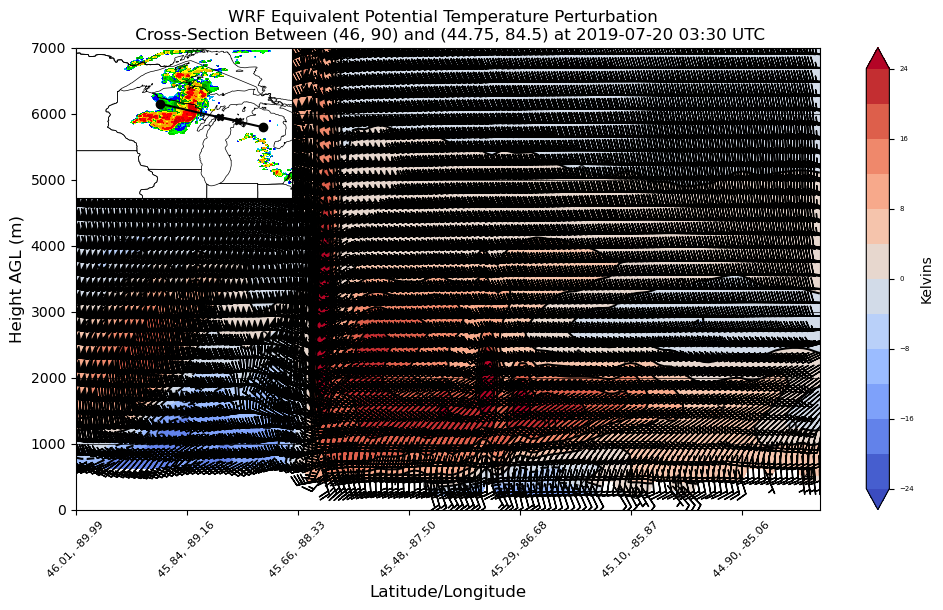

In [6]:
wrf_cross_thetaE_perturbationZ("C:\\Users\\Tony\\Desktop\\wrfoutput\\lots of levels\\wrfout_d02_2019-07-20_03_30_00",'C:\\Users\\Tony\\Desktop\\wrfoutput\\lots of levels\\wrfout_d02_2019-07-20_00_00_00')